In [1]:
using Flux
using JLD
using PyPlot

code_path = "../src"

push!(LOAD_PATH, code_path)
using AnomalyDetection

In [2]:
# load data
dataset = load("toy_data_3.jld")["data"]
x = dataset.data[:,dataset.labels.==0]
y = dataset.labels

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [3]:
# VAE settings
indim = size(x,1)
hiddendim = 10
latentdim = 2
nlayers = 2

# setup the VAE object
esize = [indim; hiddendim; hiddendim; latentdim*2] # encoder architecture
dsize = [latentdim; hiddendim; hiddendim; indim] # decoder architecture
lambda = 0.001 # KLD weight in loss function
threshold = 0 # classification threshold, is recomputed during fit!()
contamination = size(y[y.==1],1)/size(y, 1) # for automatic threshold computation
iterations = 2000
cbit = 500 # after this number of iteratiosn, callback is printed
verbfit = true
L = 1 # samples for training and classification 
# set low for training but high for classification
activation = Flux.relu
rdelta = 1e-3 # reconstruction error threshold for training stopping
model = VAEmodel(esize, dsize, lambda, threshold, contamination, iterations, cbit, verbfit, 
    L, activation = activation, rdelta = rdelta)

AnomalyDetection.VAEmodel(AnomalyDetection.VAE{Flux.Chain,AnomalyDetection.#sample_z,Flux.Chain}(Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 4)), AnomalyDetection.sample_z, Chain(Chain(Dense(2, 10, NNlib.relu), Dense(10, 10, NNlib.relu)), Dense(10, 2))), 0.001, 0, 0.1262135922330097, 2000, 500, true, 1, 0.001)

In [4]:
# fit the model
AnomalyDetection.evalloss(model, x)
AnomalyDetection.fit!(model, x)
AnomalyDetection.evalloss(model, x)

loss: 0.776748
reconstruction error: 0.781626
KL: 0.130581

loss: 0.0129223
reconstruction error: 0.0104864
KL: 2.34495

loss: 0.0067057
reconstruction error: 0.00337401
KL: 3.05175

Training ended prematurely after 1384 iterations,
reconstruction error 0.0009791585691058121 < 0.001
loss: 0.00461628
reconstruction error: 0.00147632
KL: 2.97757



In [5]:
model(x)

Tracked 2×90 Array{Float64,2}:
 0.791496  0.79364  0.817456  0.813834  …  0.0414404  0.0364767  0.0308133
 0.811664  0.81343  0.829505  0.824109     0.992058   1.0028     0.969029 

In [6]:
x

2×90 Array{Float64,2}:
 0.803442  0.804605  0.807145  0.819485  …  0.0350314  0.0613807  0.0685027
 0.821998  0.834235  0.826129  0.848182     0.973926   1.00745    0.973256 

In [7]:
AnomalyDetection.mu(model, x)

Tracked 2×90 Array{Float64,2}:
 -0.727413  -0.73006  -0.731451  …  0.0810919  0.0554793  0.0490969
 -1.05082   -1.05251  -1.05964      0.713939   0.683526   0.66298  

In [8]:
AnomalyDetection.sigma(model,x)

Tracked 2×90 Array{Float64,2}:
 0.574643   0.574256   0.574572   …  0.623726   0.621639   0.61849  
 0.0493879  0.0486795  0.0490478     0.0572578  0.0542389  0.0561664

In [9]:
AnomalyDetection.sample_z(model, x)

Tracked 2×90 Array{Float64,2}:
 -1.65409  -0.323351   0.140574  -0.675237  …  1.07264   1.17835   0.110152
 -1.15399  -1.02458   -1.09815   -1.11104      0.714786  0.627534  0.65875 

In [10]:
# predict labels
X = dataset.data
y = dataset.labels
model.L = 100 # number of samples - for classification higher is better (more stable)
tryhat = AnomalyDetection.predict(model, X)

103-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1
 1

In [11]:
# get the labels and roc stats
tryhat, tstyhat = AnomalyDetection.rocstats(dataset, dataset, model);


 Training data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 13
  tn = 89
  fp = 1
  fn = 0
precision: 0.9285714285714286
recall: 1.0
f1score: 0.9629629629629629
equal error rate: 0.005555555555555556

 Testing data performance: 
MLBase.ROCNums{Int64}
  p = 13
  n = 90
  tp = 12
  tn = 90
  fp = 0
  fn = 1
precision: 1.0
recall: 0.9230769230769231
f1score: 0.96
equal error rate: 0.038461538461538464


In [12]:
using ScikitLearn.Utils: meshgrid

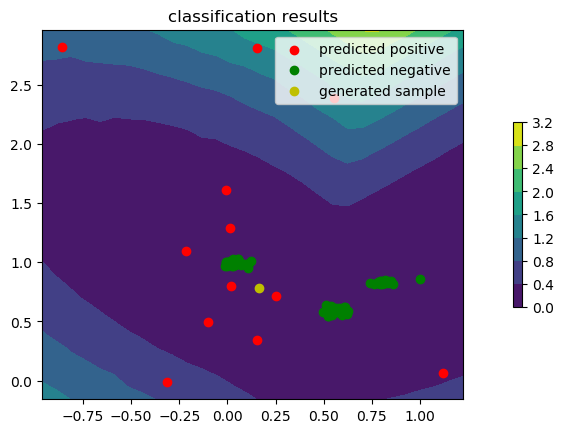

In [13]:
# plot heatmap of the fit
figure()
title("classification results")
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r")
ax = gca()
ylim = ax[:get_ylim]()
xlim = ax[:get_xlim]()
xx, yy = meshgrid(linspace(xlim[1], xlim[2], 30), linspace(ylim[1], ylim[2], 30))
zz = zeros(size(xx))
for i in 1:size(xx, 1)
    for j in 1:size(xx, 2)
        zz[i,j] = AnomalyDetection.rerr(model, [xx[i,j], yy[i,j]]).data[1]
    end
end
axsurf = ax[:contourf](xx, yy, zz)
cb = colorbar(axsurf, fraction = 0.05, shrink = 0.5, pad = 0.1)
scatter(X[1, tstyhat.==1], X[2, tstyhat.==1], c = "r", label = "predicted positive")
scatter(X[1, tstyhat.==0], X[2, tstyhat.==0], c = "g", label = "predicted negative")
b = AnomalyDetection.generate(model)
scatter(b[1], b[2], c = "y", label = "generated sample")
legend(loc = "upper right")
show()

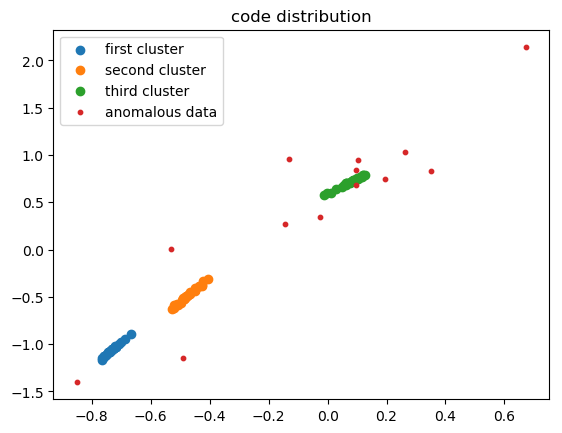

In [14]:
# what are the codes?
figure()
title("code distribution")
z1 = model.vae.encoder(X[:,1:30]).data
z2 = model.vae.encoder(X[:,31:60]).data
z3 = model.vae.encoder(X[:,61:90]).data
za = model.vae.encoder(X[:,91:end]).data

scatter(z1[1,:], z1[2,:], label = "first cluster")
scatter(z2[1,:], z2[2,:], label = "second cluster")
scatter(z3[1,:], z3[2,:], label = "third cluster")
scatter(za[1,:], za[2,:], s = 10, label = "anomalous data")
legend()
show()